# Participation score

This notebook calculates the participation score for each user.

Outpute is saved as ```outputs/participation.csv```

Participation $p_i$ for a user is defined as:

$$p_i = log(1+ obs_i + ident_i)$$

where $obs_i$ and $ident_i$ are the observations and identifications per user, respectively.


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime

# Load data

In [2]:
cities_years = {
    'London': [2018, 2019, 2020],
    'Los_Angeles': [2017, 2018, 2019, 2020],
    'San_Francisco': [2017, 2018, 2019, 2020],
}

import seaborn as sns
cities_colors = {
    'London': sns.color_palette("Blues", n_colors = 3),
    'Los_Angeles': sns.color_palette("Reds", n_colors = 4),
    'San_Francisco': sns.color_palette("Greens", n_colors = 4),
}

In [3]:
from collections import defaultdict
dfs = defaultdict(dict)
dfall = []

for city, years in cities_years.items():
    for year in years:
        print("Loading: ", city, year)
        df = pd.read_csv("../data/raw/observations_v2/CNC_{}_{}.csv".format(city, year))
        dfs[city][year] = df
        dfall.append(df)

dfall = pd.concat(dfall)
dfs['London'][2018].head()

Loading:  London 2018
Loading:  London 2019
Loading:  London 2020
Loading:  Los_Angeles 2017
Loading:  Los_Angeles 2018
Loading:  Los_Angeles 2019
Loading:  Los_Angeles 2020
Loading:  San_Francisco 2017
Loading:  San_Francisco 2018
Loading:  San_Francisco 2019
Loading:  San_Francisco 2020


,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11479007,2018-04-27 7:52:34 am BST,2018-04-27T07:52:34+00:00,Etc/UTC,2018-04-27T07:06:17+00:00,2018-04-27T09:26:56+00:00,NaN,159021,muki,research,...,lesser celandine,Plantae,species,204212,True,False,False,27624,27624,"[{'user_id': 353381, 'category': 'improving', ..."
1,11480212,2018-04-27 8:39:41 am BST,2018-04-27T08:39:41+01:00,Europe/London,2018-04-27T09:02:52+01:00,2019-01-29T21:16:34+00:00,NaN,664459,lucyrobinsonnhm,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,43329,43329,"[{'user_id': 29729, 'category': 'supporting', ..."
2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27T08:34:31+02:00,Europe/Amsterdam,2018-04-27T10:42:01+02:00,2018-04-27T13:01:49+02:00,NaN,908315,tess26,casual,...,Spanish Bluebell,Plantae,species,56095,False,False,False,2813,2813,"[{'user_id': 908315, 'category': 'leading', 'd..."
3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27T09:54:35+02:00,Europe/Amsterdam,2018-04-27T10:54:45+02:00,2018-04-27T22:23:41+02:00,NaN,796473,bryonycross,research,...,Green Alkanet,Plantae,species,156638,False,False,False,4639,4639,"[{'user_id': 160, 'category': 'improving', 'di..."
4,11482247,2018-04-27 8:42:21 am BST,2018-04-27T08:42:21+01:00,Europe/London,2018-04-27T11:09:55+01:00,2018-04-27T16:37:31+01:00,NaN,664459,lucyrobinsonnhm,research,...,London Plane,Plantae,hybrid,49664,False,False,False,5866,5866,"[{'user_id': 160, 'category': 'supporting', 'd..."


# Calculate participation

## Get number of observations and identifications

In [4]:
def get_obs_idents_per_user(dfcity):
    """ Calculate the number of observations and identifications per user 
    
    Input:
    ------
     - dfcity: pd.DataFrame
         The observations data for one city.
    
    Returns:
    -------
     - dfobsident: pd.DataFrame
         Has the columns: user_id | n_obs | n_idents
    
    """
    from collections import defaultdict
    n_obs = defaultdict(int)
    n_idents = defaultdict(int)


    for _, row in dfcity.iterrows():
        # Count observation to user that observed
        user_obs = row['user_id']
        n_obs[user_obs] += 1

        # Count identications the user did
        identifications = eval(row['identifications'])
        for ident in identifications:
            user_ident = ident['user_id']
            if user_ident != user_obs:
                n_idents[user_ident] += 1
    # Create dataframe with observations, identifications
    dfobsident = pd.DataFrame([n_obs, n_idents]).T.reset_index().convert_dtypes().fillna(0)
    dfobsident.columns = ['user_id', 'n_obs', 'n_idents']
    dfobsident
    return dfobsident

In [5]:
dfcity = dfs['San_Francisco'][2019]
dfobsident = get_obs_idents_per_user(dfcity)


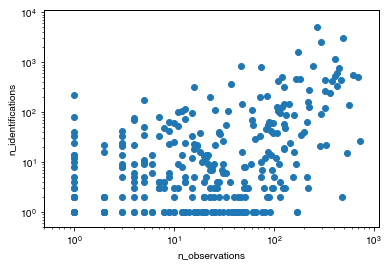

In [6]:
plt.scatter(dfobsident['n_obs'], dfobsident['n_idents'])
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xlim(xmin=0.5)
plt.gca().set_ylim(ymin=0.5)
plt.xlabel("n_observations")
plt.ylabel("n_identifications")
plt.show()

## Calculate partipication

In [7]:
def calc_participation(df):
    """ Calculate the participation score from
    observations and identifications.
    """
    df['participation'] = np.log10(1 + df['n_obs'] + df['n_idents'])
    return df

dfobsident = calc_participation(dfobsident)
dfobsident

,user_id,n_obs,n_idents,participation
0,469701,1,0,0.301030
1,402292,11,3,1.176091
2,3494,558,141,2.845098
3,34038,699,501,3.079543
4,1,166,455,2.793790
...,...,...,...,...
3348,3695873,0,1,0.301030
3349,33609,0,1,0.301030
3350,1874644,0,1,0.301030
3351,3920823,0,1,0.301030


(array([1.13e+03, 3.92e+02, 2.34e+02, 1.42e+02, 1.90e+02, 1.38e+02,
        1.95e+02, 1.80e+02, 1.55e+02, 1.17e+02, 1.44e+02, 7.40e+01,
        6.10e+01, 3.40e+01, 3.40e+01, 3.50e+01, 2.00e+01, 1.70e+01,
        2.00e+01, 8.00e+00, 5.00e+00, 8.00e+00, 5.00e+00, 6.00e+00,
        3.00e+00, 2.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00]),
 array([0.30103   , 0.41521447, 0.52939894, 0.64358342, 0.75776789,
        0.87195237, 0.98613684, 1.10032131, 1.21450579, 1.32869026,
        1.44287474, 1.55705921, 1.67124368, 1.78542816, 1.89961263,
        2.01379711, 2.12798158, 2.24216605, 2.35635053, 2.470535  ,
        2.58471948, 2.69890395, 2.81308842, 2.9272729 , 3.04145737,
        3.15564185, 3.26982632, 3.38401079, 3.49819527, 3.61237974,
        3.72656422]),
 <BarContainer object of 30 artists>)

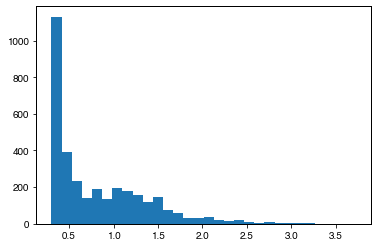

In [8]:
plt.hist(dfobsident['participation'], bins=30)

## Save participation for all cities

In [9]:
def get_participation_all_cities(dfs, cities_years):
    dfobs = []
    for city, years in cities_years.items():
        for year in years:
            print(city, year)
            dfcity = dfs[city][year]
            dfobsident = get_obs_idents_per_user(dfcity)
            dfobsident = calc_participation(dfobsident)
            dfobsident['city'] = city
            dfobsident['year'] = year
            dfobs.append(dfobsident)
    dfobs = pd.concat(dfobs)
    dfobs = dfobs.sort_values(by=['year', 'city', 'user_id'])
    return dfobs

dfobs = get_participation_all_cities(dfs, cities_years)
dfobs.to_csv("outputs/participation.csv", index=False)
dfobs

London 2018
London 2019
London 2020
Los_Angeles 2017
Los_Angeles 2018
Los_Angeles 2019
Los_Angeles 2020
San_Francisco 2017
San_Francisco 2018
San_Francisco 2019
San_Francisco 2020


,user_id,n_obs,n_idents,participation,city,year
994,1,0,72,1.863323,Los_Angeles,2017
1240,28,0,12,1.113943,Los_Angeles,2017
1326,172,0,21,1.342423,Los_Angeles,2017
1138,377,0,3,0.602060,Los_Angeles,2017
1779,462,0,1,0.301030,Los_Angeles,2017
...,...,...,...,...,...,...
3128,3934122,0,2,0.477121,San_Francisco,2020
2695,3938035,3,0,0.602060,San_Francisco,2020
3399,3955464,0,1,0.301030,San_Francisco,2020
2696,3965202,1,0,0.301030,San_Francisco,2020
